In [ ]:
import json
import gzip
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from scipy.sparse import csr_matrix

pd.set_option('display.float_format', lambda x: '%.3f' % x) # to suppress scientific notation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Dataset loading, reading and pre-processing

In [ ]:
genres_df= pd.read_json(r'/content/drive/MyDrive/Colab Notebooks/PRAssignments/BookRecommendation/Datasetes/goodreads_book_genres_initial.json', lines = True)
genres_df.head()

,book_id,genres
0,5333265,"{'history, historical fiction, biography': 1}"
1,1333909,"{'fiction': 219, 'history, historical fiction,..."
2,7327624,"{'fantasy, paranormal': 31, 'fiction': 8, 'mys..."
3,6066819,"{'fiction': 555, 'romance': 23, 'mystery, thri..."
4,287140,{'non-fiction': 3}


In [ ]:
# explode genres column (still in json format)
genres_df2 = pd.json_normalize(genres_df.genres)
genres_df2.head()

,"history, historical fiction, biography",fiction,"fantasy, paranormal","mystery, thriller, crime",poetry,romance,non-fiction,children,young-adult,"comics, graphic"
0,1.000,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,5.000,219.000,nan,nan,nan,nan,nan,nan,nan,nan
2,nan,8.000,31.000,1.000,1.000,nan,nan,nan,nan,nan
3,nan,555.000,nan,10.000,nan,23.000,nan,nan,nan,nan
4,nan,nan,nan,nan,nan,nan,3.000,nan,nan,nan


In [ ]:
genres_df2.fillna(0, inplace = True)
genres_df2.head()

,"history, historical fiction, biography",fiction,"fantasy, paranormal","mystery, thriller, crime",poetry,romance,non-fiction,children,young-adult,"comics, graphic"
0,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,5.000,219.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,8.000,31.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000
3,0.000,555.000,0.000,10.000,0.000,23.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000


In [ ]:
genres_sums = genres_df2.sum(axis = 0)
print(genres_sums)

history, historical fiction, biography   102232444.000
fiction                                  396699795.000
fantasy, paranormal                      261701592.000
mystery, thriller, crime                  94226447.000
poetry                                     6897839.000
romance                                   83142002.000
non-fiction                               48078235.000
children                                  57752225.000
young-adult                              113748515.000
comics, graphic                           19114748.000
dtype: float64


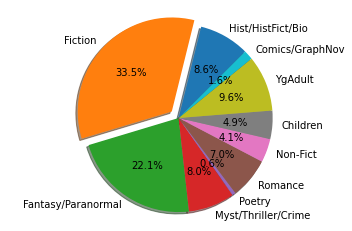

In [ ]:
labels = 'Hist/HistFict/Bio','Fiction','Fantasy/Paranormal','Myst/Thriller/Crime','Poetry','Romance','Non-Fict','Children','YgAdult', 'Comics/GraphNov' 
explode = (0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
#fig1, ax1 = plt.subplots()
plt.pie(genres_sums, labels = labels, explode = explode, shadow = True, autopct='%1.1f%%', startangle=45)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
genres_df2List=list(genres_df2.columns.values)
genres_df2List

['history, historical fiction, biography',
 'fiction',
 'fantasy, paranormal',
 'mystery, thriller, crime',
 'poetry',
 'romance',
 'non-fiction',
 'children',
 'young-adult',
 'comics, graphic']

In [ ]:
genres_df2List=['history', 'historical-fiction', 'biography','fiction','fantasy', 'paranormal','mystery', 'thriller', 'crime','poetry','romance','non-fiction','children','young-adult','comics',' graphic','young','adult']
len(genres_df2List)

18

In [ ]:
genres = pd.DataFrame(genres_df2List).drop_duplicates(0)
genres.columns = ['tag_name']
genres

,tag_name
0,history
1,historical-fiction
2,biography
3,fiction
4,fantasy
5,paranormal
6,mystery
7,thriller
8,crime
9,poetry


In [ ]:
books = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PRAssignments/BookRecommendation/Datasetes/books.csv')
ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PRAssignments/BookRecommendation/Datasetes/ratings.csv')
tags = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PRAssignments/BookRecommendation/Datasetes/tags.csv')
bookTags = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PRAssignments/BookRecommendation/Datasetes/book_tags.csv')
print(tags.shape)
print(bookTags.shape)

(34252, 2)
(999912, 3)


1)Tags collects all the tags included in 'bookTags' and explains their meaning.

In [ ]:
print(tags.shape)
tags.head(34252)

(34252, 2)


,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-
...,...,...
34247,34247,Ｃhildrens
34248,34248,Ｆａｖｏｒｉｔｅｓ
34249,34249,Ｍａｎｇａ
34250,34250,ＳＥＲＩＥＳ


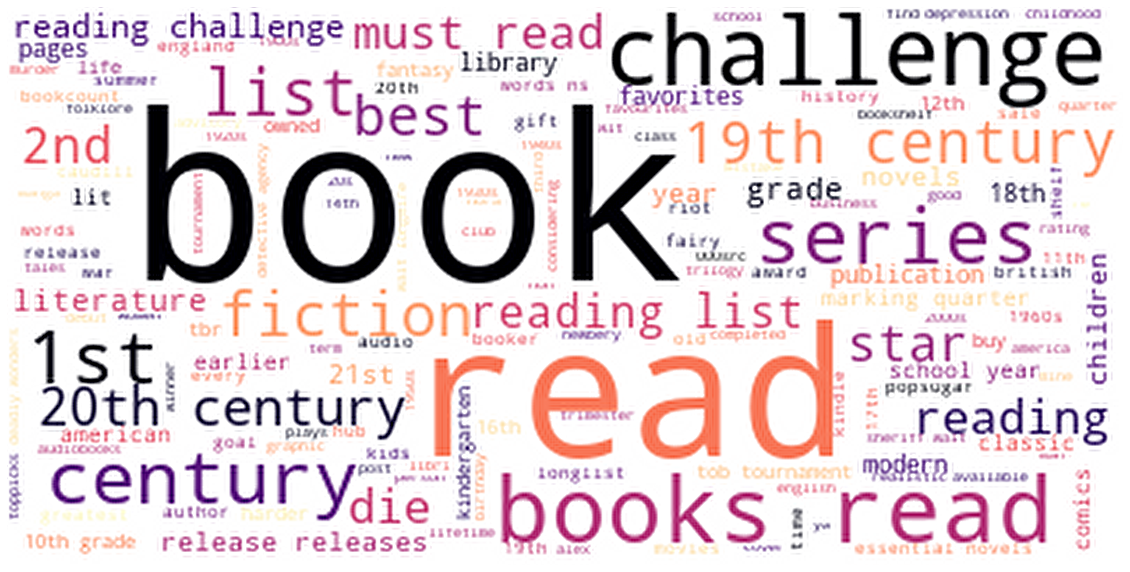

In [ ]:
# build a wordcloud from all_tags
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import itertools

full_text = itertools.islice(tags.tag_name, 5000)
full_text = list(full_text)
full_text

bunch_text = " ".join(str(text) for text in full_text[:1000])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", colormap= "magma").generate(bunch_text)

plt.figure(figsize=[20,20])
plt.imshow(wordcloud, interpolation="sinc")
plt.axis("off")
plt.show()

2) Book Tags contains all the tags associated to each and every book included in the analysis.

In [ ]:
bookTags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


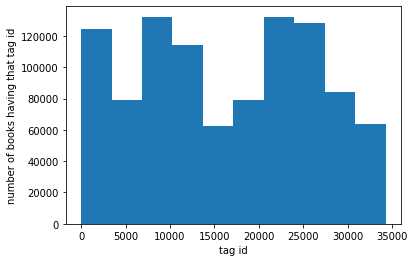

In [ ]:
plt.hist(bookTags['tag_id'])
plt.xlabel("tag id")
plt.ylabel("number of books having that tag id")
plt.show()

In [ ]:
print(bookTags.shape)# 999,912 rows imported x 3 columns imported
print(len(bookTags.goodreads_book_id.unique()))  # As expected, there are 10,000 books in total
print(len(bookTags.tag_id.unique())) # As expected, there are 34,252 different tags in total

(999912, 3)
10000
34252


# 2. Content-Based Filtering (Tag-Based)

In [ ]:
showingTagName = pd.merge(bookTags, tags, on = 'tag_id')
showingTagName.sort_values('goodreads_book_id').head(1000)

,goodreads_book_id,tag_id,count,tag_name
0,1,30574,167697,to-read
258362,1,33165,338,youth
250046,1,17213,347,kindle
246919,1,27535,348,shelfari-favorites
245888,1,16799,351,juvenile
...,...,...,...,...
397406,21,1642,61,adult
483116,21,21689,1121,non-fiction
246928,21,27535,52,shelfari-favorites
481283,21,21773,1845,nonfiction


In [ ]:
mostUsedTags = showingTagName.groupby(['tag_name'], as_index = False) \
                      .agg({'goodreads_book_id' : 'count'}) \
                      .rename(columns = {'goodreads_book_id' : 'number'}) \
                      .sort_values('number', ascending = False)
mostUsedTags.head()

,tag_name,number
30574,to-read,9983
11557,favorites,9881
22743,owned,9858
5207,books-i-own,9799
8717,currently-reading,9776


So I have used the genres to remove irrelevant tags.

In [ ]:
genres.head()

,tag_name
0,history
1,historical-fiction
2,biography
3,fiction
4,fantasy


In [ ]:
# First I convert the genres to a list
genreList = genres['tag_name'].tolist()
len(genreList)

18

In [ ]:
len(tags.tag_name.unique())   # the original tag dataset included 34,252 tags

34252

In [ ]:
genreTags = tags.loc[tags['tag_name'].isin(genreList)]
len(genreTags)    

17

In [ ]:
genreTags

,tag_id,tag_name
1642,1642,adult
4605,4605,biography
6857,6857,children
7778,7778,comics
8517,8517,crime
11305,11305,fantasy
11743,11743,fiction
14487,14487,historical-fiction
14552,14552,history
20939,20939,mystery


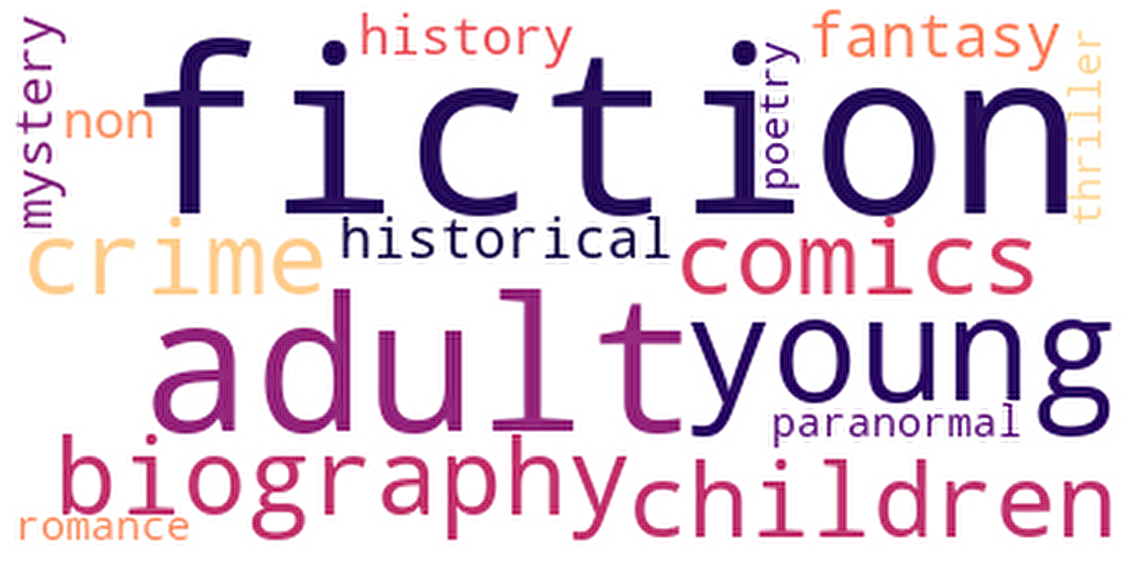

In [ ]:
# build a wordcloud from all_tags
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import itertools

full_text = itertools.islice(genreTags.tag_name, 5000)
full_text = list(full_text)
full_text

bunch_text = " ".join(str(text) for text in full_text[:1500])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", colormap= "magma").generate(bunch_text)

plt.figure(figsize=[20,20])
plt.imshow(wordcloud, interpolation="sinc")
plt.axis("off")
plt.show()

In [ ]:
mostCommonTags = pd.merge(bookTags, genreTags, on = ['tag_id'])

In [ ]:
stringedTags = mostCommonTags.groupby('goodreads_book_id')['tag_name'].apply(lambda x: "%s" % ' '.join(x)).reset_index()
stringedTags.head(20) #now unnecessary tages removed

,goodreads_book_id,tag_name
0,1,fantasy young-adult fiction children paranorma...
1,2,fantasy young-adult fiction children paranorma...
2,3,fantasy young-adult fiction children paranorma...
3,5,fantasy young-adult fiction children paranorma...
4,6,fantasy young-adult fiction children paranorma...
5,8,fantasy young-adult fiction children paranorma...
6,10,fantasy young-adult fiction children paranorma...
7,11,fantasy young-adult fiction adult
8,13,fantasy young-adult fiction adult
9,21,fiction adult history non-fiction


In [ ]:
stringedTags.shape

(9997, 2)

In [ ]:
# I go retrieve the author and book information from the book dataset, so that I will be able to actually see
# the title of the book instead of just seeing the id.

stringedTags = pd.merge(stringedTags, books[['book_id', 'authors', 'title']], left_on = ['goodreads_book_id'], \
                       right_on = ['book_id']).drop('book_id', axis = 1)

stringedTags.head()

,goodreads_book_id,tag_name,authors,title
0,1,fantasy young-adult fiction children paranorma...,"J.K. Rowling, Mary GrandPré",Harry Potter and the Half-Blood Prince (Harry ...
1,2,fantasy young-adult fiction children paranorma...,"J.K. Rowling, Mary GrandPré",Harry Potter and the Order of the Phoenix (Har...
2,3,fantasy young-adult fiction children paranorma...,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...
3,5,fantasy young-adult fiction children paranorma...,"J.K. Rowling, Mary GrandPré, Rufus Beck",Harry Potter and the Prisoner of Azkaban (Harr...
4,6,fantasy young-adult fiction children paranorma...,"J.K. Rowling, Mary GrandPré",Harry Potter and the Goblet of Fire (Harry Pot...


In [ ]:
# First of all, I put everything in lowercase and I remove the space between the name and the surname, to make it count
# as one single word all the time.
stringedTags['authors'] = stringedTags['authors'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
stringedTags.head()

,goodreads_book_id,tag_name,authors,title
0,1,fantasy young-adult fiction children paranorma...,"j.k.rowling,marygrandpré",Harry Potter and the Half-Blood Prince (Harry ...
1,2,fantasy young-adult fiction children paranorma...,"j.k.rowling,marygrandpré",Harry Potter and the Order of the Phoenix (Har...
2,3,fantasy young-adult fiction children paranorma...,"j.k.rowling,marygrandpré",Harry Potter and the Sorcerer's Stone (Harry P...
3,5,fantasy young-adult fiction children paranorma...,"j.k.rowling,marygrandpré,rufusbeck",Harry Potter and the Prisoner of Azkaban (Harr...
4,6,fantasy young-adult fiction children paranorma...,"j.k.rowling,marygrandpré",Harry Potter and the Goblet of Fire (Harry Pot...


In [ ]:
# With the same operation, I remove the comma between the names as well
stringedTags['authors'] = stringedTags['authors'].astype('str').apply(lambda x: str.lower(x.replace(",", " ")))
stringedTags.head(10)

,goodreads_book_id,tag_name,authors,title
0,1,fantasy young-adult fiction children paranorma...,j.k.rowling marygrandpré,Harry Potter and the Half-Blood Prince (Harry ...
1,2,fantasy young-adult fiction children paranorma...,j.k.rowling marygrandpré,Harry Potter and the Order of the Phoenix (Har...
2,3,fantasy young-adult fiction children paranorma...,j.k.rowling marygrandpré,Harry Potter and the Sorcerer's Stone (Harry P...
3,5,fantasy young-adult fiction children paranorma...,j.k.rowling marygrandpré rufusbeck,Harry Potter and the Prisoner of Azkaban (Harr...
4,6,fantasy young-adult fiction children paranorma...,j.k.rowling marygrandpré,Harry Potter and the Goblet of Fire (Harry Pot...
5,8,fantasy young-adult fiction children paranorma...,j.k.rowling marygrandpré,"Harry Potter Boxed Set, Books 1-5 (Harry Potte..."
6,10,fantasy young-adult fiction children paranorma...,j.k.rowling,"Harry Potter Collection (Harry Potter, #1-6)"
7,11,fantasy young-adult fiction adult,douglasadams,The Hitchhiker's Guide to the Galaxy (Hitchhik...
8,13,fantasy young-adult fiction adult,douglasadams,The Ultimate Hitchhiker's Guide to the Galaxy
9,21,fiction adult history non-fiction,billbryson,A Short History of Nearly Everything


In [ ]:
# Then I add the author(s) to the stringed genre-tags to get more accurate recommendation
stringedTags['all_tags'] = stringedTags['tag_name'] + " " + stringedTags['authors']

In [ ]:
# A example with one of Harry Potter's series book:
stringedTags.all_tags[1]

'fantasy young-adult fiction children paranormal mystery romance j.k.rowling marygrandpré'

In [ ]:
stringedTags.head()

,goodreads_book_id,tag_name,authors,title,all_tags
0,1,fantasy young-adult fiction children paranorma...,j.k.rowling marygrandpré,Harry Potter and the Half-Blood Prince (Harry ...,fantasy young-adult fiction children paranorma...
1,2,fantasy young-adult fiction children paranorma...,j.k.rowling marygrandpré,Harry Potter and the Order of the Phoenix (Har...,fantasy young-adult fiction children paranorma...
2,3,fantasy young-adult fiction children paranorma...,j.k.rowling marygrandpré,Harry Potter and the Sorcerer's Stone (Harry P...,fantasy young-adult fiction children paranorma...
3,5,fantasy young-adult fiction children paranorma...,j.k.rowling marygrandpré rufusbeck,Harry Potter and the Prisoner of Azkaban (Harr...,fantasy young-adult fiction children paranorma...
4,6,fantasy young-adult fiction children paranorma...,j.k.rowling marygrandpré,Harry Potter and the Goblet of Fire (Harry Pot...,fantasy young-adult fiction children paranorma...


In [ ]:
stringedTags.to_csv('/content/drive/MyDrive/Colab Notebooks/PRAssignments/BookRecommendation/Datasetes/stringedTags.csv')

In [ ]:
len(stringedTags.goodreads_book_id.unique())

9997

#Tag+Author based RS

In [ ]:
# for tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

tfidf_rev = tfidf_vectorizer.fit_transform((stringedTags['all_tags']))
tfidf_rev

<9997x6209 sparse matrix of type '<class 'numpy.float64'>'
	with 65306 stored elements in Compressed Sparse Row format>

In [ ]:
# for count
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()

count_rev = count_vectorizer.fit_transform((stringedTags['all_tags']))
count_rev

<9997x6209 sparse matrix of type '<class 'numpy.int64'>'
	with 65306 stored elements in Compressed Sparse Row format>

In [ ]:
stringedTags[stringedTags['authors'] == 'j.k.rowling marygrandpré']

,goodreads_book_id,tag_name,authors,title,all_tags
0,1,fantasy young-adult fiction children paranorma...,j.k.rowling marygrandpré,Harry Potter and the Half-Blood Prince (Harry ...,fantasy young-adult fiction children paranorma...
1,2,fantasy young-adult fiction children paranorma...,j.k.rowling marygrandpré,Harry Potter and the Order of the Phoenix (Har...,fantasy young-adult fiction children paranorma...
2,3,fantasy young-adult fiction children paranorma...,j.k.rowling marygrandpré,Harry Potter and the Sorcerer's Stone (Harry P...,fantasy young-adult fiction children paranorma...
4,6,fantasy young-adult fiction children paranorma...,j.k.rowling marygrandpré,Harry Potter and the Goblet of Fire (Harry Pot...,fantasy young-adult fiction children paranorma...
5,8,fantasy young-adult fiction children paranorma...,j.k.rowling marygrandpré,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...",fantasy young-adult fiction children paranorma...
1276,15881,fantasy young-adult fiction children paranorma...,j.k.rowling marygrandpré,Harry Potter and the Chamber of Secrets (Harry...,fantasy young-adult fiction children paranorma...
3488,99298,fantasy young-adult fiction children paranormal,j.k.rowling marygrandpré,"The Harry Potter Collection 1-4 (Harry Potter,...",fantasy young-adult fiction children paranorma...
3890,136251,fantasy young-adult fiction children paranorma...,j.k.rowling marygrandpré,Harry Potter and the Deathly Hallows (Harry Po...,fantasy young-adult fiction children paranorma...


In [ ]:
#insert goodreads_book_id
g = 3
index = np.where(stringedTags['goodreads_book_id'] == g)[0][0]
read_book = stringedTags.iloc[[index]]
read_book

,goodreads_book_id,tag_name,authors,title,all_tags
2,3,fantasy young-adult fiction children paranorma...,j.k.rowling marygrandpré,Harry Potter and the Sorcerer's Stone (Harry P...,fantasy young-adult fiction children paranorma...


# Content based RS with TfidfVectorizer

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
book_tfidf = tfidf_vectorizer.transform(read_book['all_tags'])
cos_similarity_tfidf = map(lambda x: cosine_similarity(book_tfidf, x), tfidf_rev)
output = list(cos_similarity_tfidf)

# Content based RS with CountVectorizer

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
book_count = count_vectorizer.transform(read_book['all_tags'])
cos_similarity_countv = map(lambda x: cosine_similarity(book_count, x), count_rev)
output2 = list(cos_similarity_countv)

#Top recommendations

In [ ]:
#This function takes input as top= how many top recommendation we want to see,
# ds=dataframe(here, stringedTags) and scores= cosine similarity score of other bookes with the given id's book
# and give output -->recommendation(goodreads book id, author names, title and similarity score with the given id) 

def get_recommendation(top, ds, scores):
  recommendation = pd.DataFrame(columns = ['goodreads_book_id', 'authors', 'title', 'score'])
  count = 0
  for i in top:
    if stringedTags.iloc[i, 0]<=10000 and scores[count]>=0.7 :
      recommendation.at[count, 'goodreads_book_id'] = stringedTags.iloc[i, 0]
      recommendation.at[count, 'authors'] = stringedTags.iloc[i, 2]
      recommendation.at[count, 'title'] = stringedTags.iloc[i, 3]
      recommendation.at[count, 'score'] =  scores[count]
      count += 1
  return recommendation

In [ ]:
n=200

In [ ]:
# for tfidf
top = sorted(range(len(output)), key=lambda i: output[i], reverse=True)[:n]
list_scores = [output[i][0][0] for i in top]
comparison=get_recommendation(top, stringedTags, list_scores)
get_recommendation(top, stringedTags, list_scores)


,goodreads_book_id,authors,title,score
0,3,j.k.rowling marygrandpré,Harry Potter and the Sorcerer's Stone (Harry P...,1.000
1,6,j.k.rowling marygrandpré,Harry Potter and the Goblet of Fire (Harry Pot...,1.000
2,1,j.k.rowling marygrandpré,Harry Potter and the Half-Blood Prince (Harry ...,1.000
3,2,j.k.rowling marygrandpré,Harry Potter and the Order of the Phoenix (Har...,0.988
4,8,j.k.rowling marygrandpré,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...",0.988
5,5,j.k.rowling marygrandpré rufusbeck,Harry Potter and the Prisoner of Azkaban (Harr...,0.988
6,10,j.k.rowling,"Harry Potter Collection (Harry Potter, #1-6)",0.986
7,2002,j.k.rowling,Harry Potter Schoolbooks Box Set: Two Classic ...,0.980
8,9475,jennynimmo,Midnight for Charlie Bone (The Children of the...,0.779
9,8948,darrenshan,"Sons of Destiny (Cirque Du Freak, #12)",0.743


In [ ]:
# for count
top = sorted(range(len(output2)), key=lambda i: output2[i], reverse=True)[:n]
list_scores = [output2[i][0][0] for i in top]
get_recommendation(top, stringedTags, list_scores)

,goodreads_book_id,authors,title,score
0,3,j.k.rowling marygrandpré,Harry Potter and the Sorcerer's Stone (Harry P...,1.000
1,6,j.k.rowling marygrandpré,Harry Potter and the Goblet of Fire (Harry Pot...,1.000
2,1,j.k.rowling marygrandpré,Harry Potter and the Half-Blood Prince (Harry ...,1.000
3,2,j.k.rowling marygrandpré,Harry Potter and the Order of the Phoenix (Har...,0.949
4,5,j.k.rowling marygrandpré rufusbeck,Harry Potter and the Prisoner of Azkaban (Harr...,0.949
5,8,j.k.rowling marygrandpré,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...",0.949
6,10,j.k.rowling,"Harry Potter Collection (Harry Potter, #1-6)",0.949
7,2002,j.k.rowling,Harry Potter Schoolbooks Box Set: Two Classic ...,0.949
8,9475,jennynimmo,Midnight for Charlie Bone (The Children of the...,0.943
9,6294,dianawynnejones,"Howl's Moving Castle (Howl's Moving Castle, #1)",0.943
